In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import pickle
import copy

import itertools
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from sklearn import metrics
from sklearn import utils
import xgboost as xgb

matplotlib.rcParams["figure.facecolor"] = 'white'
%cd /home/naodell/work/hgcal/ECONAutoencoderStudy

/home/naodell/work/hgcal/ECONAutoencoderStudy


## Configuration

### Plotting styling

In [4]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'
colors['AutoEncoderTelescopeMSE'] = 'tab:blue'
colors['AutoEncoderStride'] = 'tab:orange'
colors['AutoEncoderQKerasTTbar'] = 'tab:red'
colors['AutoEncoderQKerasEle'] = 'tab:green'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'
styles['AutoEncoderTelescopeMSE'] = '-'
styles['AutoEncoderStride'] = '-'
styles['AutoEncoderQKerasTTbar'] = '--'
styles['AutoEncoderQKerasEle'] = '--'

markers = {}
markers['Threshold0'] = 'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'
markers['AutoEncoderTelescopeMSE'] = 'o'
markers['AutoEncoderStride'] = 'o'
markers['AutoEncoderQKerasTTbar'] = 'o'
markers['AutoEncoderQKerasEle'] = 'o'



legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'
legends['AutoEncoderTelescopeMSE'] = 'AE Telescope MSE'
legends['AutoEncoderStride'] = 'AE Stride'
legends['AutoEncoderQKerasTTbar'] = 'AE QKeras ttbar'
legends['AutoEncoderQKerasEle'] = 'AE QKeras Ele'

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderTelescopeMSE', 
                'AutoEncoderStride',
                'AutoEncoderQKerasTTbar',
                'AutoEncoderQKerasEle',
               ]

### Input files and FE algorithms to be studied

200 PU electrons and pure 200PU events are loaded

In [5]:
version = '210611'
fig_dir = 'img/electron_pu_autoencoder_{}'.format(version)
algo_files = {}

# Read signal driven files
directory_elec = 'data/3_22_1/electron_photon_signaldriven/v_1_2021-06-20'
directory_pu = 'data/3_22_1/pu_for_id_signaldriven/v_1_2021-06-20/MinBias/'
fes = ['Threshold0', 'Threshold', 'Mixedbcstc',
       'AutoEncoderTelescopeMSE', 'AutoEncoderStride',
       'AutoEncoderQKerasTTbar', 'AutoEncoderQKerasEle'
      ]

for fe in fes:
    algo_files[fe] = (glob(f'{directory_elec}/electrons/*.hdf5'), glob(f'{directory_pu}/*.hdf5'))

## Loading and preprocessing dataframes
Selection cuts (in addition to those already applied before):
- Gen electron $15 < p_T < 150 GeV$
- Extrapolated gen electron eta between 1.6 and 2.9
- PU cluster eta between 1.6 and 2.9

Additionally label electrons and positrons as `1` and PU clusters as `0`

In [6]:
ptmin=15
ptmax=150
etamin=1.6
etamax=2.9
algos_dfs = {}

for algo_name, files in tqdm(algo_files.items()):
    dfs = []
    
    for file in tqdm(files[0], desc = algo_name, leave = False):
        with pd.HDFStore(file, mode='r') as store:
            df = store[algo_name]
            store.close()
        
        df = df.query(f'genpart_pt > {ptmin} & genpart_pt < {ptmax}')
        df = df.query(f'genpart_exeta > {etamin} & genpart_exeta < {etamax}')
        df = df.query('matches == True')
        df['genpart_pid'].replace([-11,11], 1, inplace=True)
        dfs.append(df)
        
    for file in tqdm(files[1], desc = algo_name, leave = False):
        with pd.HDFStore(file, mode='r') as store:
            df = store[algo_name]
            store.close()
        
        df['genpart_pid'] = 0
        df = df.query(f'cl3d_eta > {etamin} & cl3d_eta < {etamax}')
        dfs.append(df)
    
    algos_dfs[algo_name] = pd.concat(dfs)


  0%|          | 0/7 [00:00<?, ?it/s]

Threshold0:   0%|          | 0/17 [00:00<?, ?it/s]

Threshold0:   0%|          | 0/31 [00:00<?, ?it/s]

Threshold:   0%|          | 0/17 [00:00<?, ?it/s]

Threshold:   0%|          | 0/31 [00:00<?, ?it/s]

Mixedbcstc:   0%|          | 0/17 [00:00<?, ?it/s]

Mixedbcstc:   0%|          | 0/31 [00:00<?, ?it/s]

AutoEncoderTelescopeMSE:   0%|          | 0/17 [00:00<?, ?it/s]

AutoEncoderTelescopeMSE:   0%|          | 0/31 [00:00<?, ?it/s]

AutoEncoderStride:   0%|          | 0/17 [00:00<?, ?it/s]

AutoEncoderStride:   0%|          | 0/31 [00:00<?, ?it/s]

AutoEncoderQKerasTTbar:   0%|          | 0/17 [00:00<?, ?it/s]

AutoEncoderQKerasTTbar:   0%|          | 0/31 [00:00<?, ?it/s]

AutoEncoderQKerasEle:   0%|          | 0/17 [00:00<?, ?it/s]

AutoEncoderQKerasEle:   0%|          | 0/31 [00:00<?, ?it/s]

Retrieve the number of PU clusters per event. 

The number of events stored in the dataframe is not the total number of events since preselection cuts are applied. The total number of events kept during the preprocessing is retrieved in order to compute the number of clusters per event.

In [7]:
# Compute the average number of clusters per event stored in the dataframe
nclusters_per_event = {}
for fe,df in algos_dfs.items():
    df_pu = df[df.genpart_pid==0]
    clusters_per_event = df_pu.groupby('event').count()
    nclusters_per_event[fe] = np.mean(clusters_per_event.genpart_pid)
    
# Retrieve the total number of events before preselection
events_pu = {}
for fe,files in algo_files.items():
    evts = 0
    for file in files[1]:
        with open(os.path.splitext(file)[0]+'.txt', 'r') as f:
            lines = f.readlines()
            evts += int(lines[0])
        events_pu[fe] = evts
        
# Compute the number of events in the dataframe
events_pu_stored = {}
for fe,df in algos_dfs.items():
    df_pu = df[df.genpart_pid==0]
    events = np.unique(df_pu.reset_index()['event']).shape[0]
    events_pu_stored[fe] = events

# Correct the number of clusters / event based on the total number of events
for fe, nclusters in nclusters_per_event.items():
    nclusters_per_event[fe] = nclusters*events_pu_stored[fe]/events_pu[fe]
    print(fe, nclusters_per_event[fe], 'clusters / event')

Threshold0 0.01244042032426066 clusters / event
Threshold 0.010029628811719022 clusters / event
Mixedbcstc 0.01431752516608697 clusters / event
AutoEncoderTelescopeMSE 0.008207732935828778 clusters / event
AutoEncoderStride 0.008226135924474133 clusters / event
AutoEncoderQKerasTTbar 0.007453210401369183 clusters / event
AutoEncoderQKerasEle 0.007766061208340234 clusters / event


In [8]:
for fe,df in algos_dfs.items():
    print(fe, '\n > background =', df[df.genpart_pid==0].shape[0], 'signal =', df[df.genpart_pid==1].shape[0])

Threshold0 
 > background = 676 signal = 69395
Threshold 
 > background = 545 signal = 69395
Mixedbcstc 
 > background = 778 signal = 69392
AutoEncoderTelescopeMSE 
 > background = 446 signal = 69389
AutoEncoderStride 
 > background = 447 signal = 69387
AutoEncoderQKerasTTbar 
 > background = 405 signal = 69388
AutoEncoderQKerasEle 
 > background = 422 signal = 69385


In [9]:
for name,df in algos_dfs.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

Check cluster eta and pT distributions. Note that this is the uncorrected pT that is plotted.

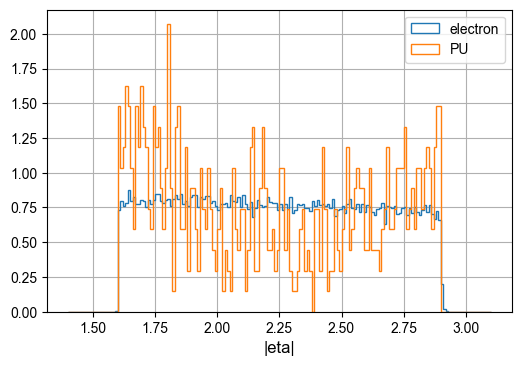

In [10]:
plt.figure(dpi=100)
plt.hist(algos_dfs['Threshold0'].query('genpart_pid==1').cl3d_abseta, 
         histtype='step', density=True, bins=np.arange(1.4, 3.1, 0.01),
         label='electron')
plt.hist(algos_dfs['Threshold0'].query('genpart_pid==0').cl3d_abseta,
         histtype='step', density=True, bins=np.arange(1.4, 3.1, 0.01),
         label='PU')
plt.grid()
plt.legend()
plt.xlabel('|eta|')
plt.show()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, cursive


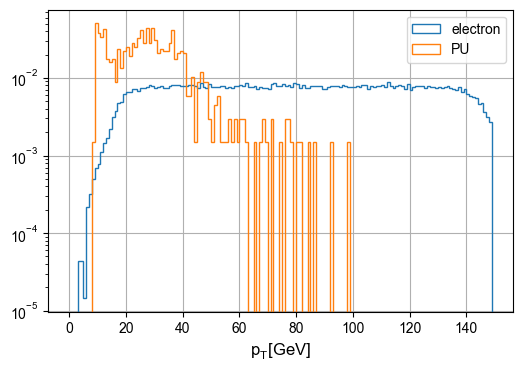

In [11]:
plt.figure(dpi=100)
plt.hist(algos_dfs['Threshold0'].query('genpart_pid==1').cl3d_pt, 
         histtype='step', density=True, bins=np.arange(0, 150, 1),
         label='electron')
plt.hist(algos_dfs['Threshold0'].query('genpart_pid==0').cl3d_pt,
         histtype='step', density=True, bins=np.arange(0, 150, 1),
         label='PU')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel(r'$p_T [GeV]$')
plt.show()

## BDT training

In [12]:

def train_xgb(df, inputs, output, hyperparams):
    X, y  = utils.shuffle(df[inputs], df[output], random_state=1234)
    weight_elec = y[y==0].shape[0]/y[y==1].shape[0]
    w_train = np.where(y==1, weight_elec, 1.)
    print("  > Electron size:", y[y==1].shape[0])
    print("  > PU size:", y[y==0].shape[0])
    print("  > Applying weight of", weight_elec, "to electrons to balance the sample")
    # The full sample is used for training
    train = xgb.DMatrix(data=X,label=y, weight=w_train, feature_names=inputs)
    test = xgb.DMatrix(data=df[inputs],label=df[output], feature_names=inputs)
    params_cp = copy.deepcopy(hyperparams)
    params_cp.pop('n_estimators')
    booster = xgb.train(params_cp, train, num_boost_round=hyperparams['n_estimators'])
    df['bdt_output'] = booster.predict(test)
    fpr, tpr, threshold = metrics.roc_curve(df[output], df['bdt_output'])
    return booster, fpr, tpr, threshold

def train_all(name_dfs, inputs, output, hyperparams):
    boosters = {}
    fprs = {}
    tprs = {}
    thresholds = {}
    for name,df in name_dfs.items():
        print(' FE algorithm', name)
        boosters[name], fprs[name], tprs[name], thresholds[name] = train_xgb(df, inputs, output, hyperparams)
    return boosters, fprs, tprs, thresholds


In [13]:
inputs ={
    'extended':['cl3d_abseta','cl3d_showerlength',
    'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
    'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean',
    'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10',
    'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90'],
}
output = 'genpart_pid'

param = {}
param['nthread'] = 5  # limit number of threads to 5
param['learning_rate'] = 0.05 # initial learning rate
param['max_depth'] = 4  # maximum depth of a tree
param['lambda'] = 10 # L2 regularization
param['alpha'] = 10 # L1 regularization
param['n_estimators'] = 50 
param['subsample'] = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on
param['objective'] = 'binary:logistic'

boosters = {}
fprs = {}
tprs = {}
thresholds = {}
for name, features in inputs.items():
    print('Training with feature set "', name, '"')
    boosters[name], fprs[name], tprs[name], thresholds[name] = train_all(algos_dfs, features, output, param)

Training with feature set " extended "
 FE algorithm Threshold0
  > Electron size: 69395
  > PU size: 676
  > Applying weight of 0.009741335831111751 to electrons to balance the sample
[20:21:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 FE algorithm Threshold
  > Electron size: 69395
  > PU size: 545
  > Applying weight of 0.00785359175733122 to electrons to balance the sample
[20:21:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 FE algorithm Mixedbcstc
  > Electron size: 69392
  > PU size: 778
  > Applying weight of 0.011211667050956883 to electrons to balance the sample
[20:21:03] WARNING: .

### Background efficiency vs signal efficiency

Note that ROC curves are not directly comparable because the population of initial (reconstructed) PU clusters and their number differ between algorithms

In [ ]:
#build ROC
tpr_ratio = np.arange(0.9, 1.0, 0.001)
matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2, 1, figsize=(15,20))
fpr_ref = fprs['extended'][ref_name]
tpr_ref = tprs['extended'][ref_name]
for name in plotted_algo:
    ## New inputs
    fpr = fprs['extended'][name]
    tpr = tprs['extended'][name]
    roc_auc = metrics.auc(fpr, tpr)    
    axs[0].plot(tpr,fpr, label = legends[name],
                c=colors[name], ls=styles[name])
    if name!=ref_name:
        ratio = np.interp(tpr_ratio, tpr, fpr) / np.interp(tpr_ratio, tpr_ref, fpr_ref)
        axs[1].plot(tpr_ratio,ratio, c=colors[name], ls=styles[name])
        
axs[0].legend(loc = 'upper left', fontsize=16)
axs[0].grid(which='both')
axs[0].set_xlim(0.9,1.001)
axs[0].set_yscale('log')
axs[0].set_ylim(0.03,1)
axs[0].set_xlabel('Signal efficiency')
axs[0].set_ylabel('Background efficiency') 

axs[1].grid(which='both')
axs[1].set_xlim(0.9,1.001)
axs[1].set_ylim(0.9,2.5)
axs[1].set_xlabel('Signal efficiency')
axs[1].set_ylabel('Ratio to All TC')

plt.show()

### PU clusters per event vs signal efficiency
Although this plot is better than ROC curves for comparison since the number of PU clusters is normalized per event, the curves still cannot be directly compared because the initial population of PU clusters still differ between FE options. 

This is due to the fact that the energy scale is not necessarily flat vs pT, and the 20GeV selection cut applied on the corrected pT doesn't have the same effect for all the different FE options. Algorithms with a lower energy scale around 20GeV will have artificially better performance because of less low pT clusters promoted above the 20GeV cut.

In [ ]:
tpr_ratio = np.arange(0.9, 1.0, 0.001)
matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2, 1, figsize=(15,20))
fpr_ref = fprs['extended'][ref_name]*nclusters_per_event[ref_name]
tpr_ref = tprs['extended'][ref_name]
for name in plotted_algo:
    ## New inputs
    fpr = fprs['extended'][name]*nclusters_per_event[name]
    tpr = tprs['extended'][name]
    roc_auc = metrics.auc(fpr, tpr)    
    axs[0].plot(tpr,fpr, label = legends[name],
                c=colors[name], ls=styles[name])
    if name!=ref_name:
        ratio = np.interp(tpr_ratio, tpr, fpr) / np.interp(tpr_ratio, tpr_ref, fpr_ref)
        axs[1].plot(tpr_ratio,ratio, c=colors[name], ls=styles[name])
axs[0].legend(loc = 'upper left', fontsize=16)
axs[0].grid(which='both')
axs[0].set_xlim(0.9,1.001)
axs[0].set_yscale('log')
axs[0].set_ylim(0.0008,0.02)
axs[0].set_xlabel('Signal efficiency')
axs[0].set_ylabel('PU clusters / event') 

axs[1].grid(which='both')
axs[1].set_xlim(0.9,1.001)
axs[1].set_ylim(0.8,2)
axs[1].set_xlabel('Signal efficiency')
axs[1].set_ylabel('Ratio to All TC')

plt.show()

## Checking signal efficiencies

Extracting electrons from the full dataframe and defining eta and pT bins (gen particle level). Eta bins are 0.1 units wide, and pT bins are 5 GeV wide.

In [ ]:
dfs_ele = {}
for name,df in algos_dfs.items():
    df_ele = df[df.genpart_pid==1]
    df_ele['genpart_abseta'] = np.abs(df_ele.genpart_exeta)
    df_ele['genpart_bineta'] = ((df_ele.genpart_abseta - etamin)/0.1).astype('int32')
    df_ele['genpart_binpt'] = ((df_ele.genpart_pt - ptmin)/5).astype('int32')
    dfs_ele[name] = df_ele

Extracting BDT output cuts that provide a 99% signal efficiency inclusively.

In [17]:
bdt_thresholds = {}
for name, threshold in thresholds['extended'].items():
    tpr = tprs['extended'][name]
    bdt_thresholds[name] = np.interp(0.99, tpr, threshold)
    print(name, bdt_thresholds[name])

Threshold0 0.1870884989472953
Threshold 0.20262900665402414
Mixedbcstc 0.20436171412467966
AutoEncoderTelescopeMSE 0.2296222436800599
AutoEncoderStride 0.2165602414309978
AutoEncoderQKerasTTbar 0.22889697170257586
AutoEncoderQKerasEle 0.19852756348748993


In [18]:
def efficiency(group, cut):
    tot = group.shape[0]
    sel = group[group.bdt_output > cut].shape[0]
    return sel/tot

### Efficiency vs eta

In [19]:
efficiencies_vs_eta = {}
for name,df in dfs_ele.items():
    full = xgb.DMatrix(data=df[inputs['extended']], label=df[output], feature_names=inputs['extended'])
    df['bdt_output'] = boosters['extended'][name].predict(full)
    efficiencies_vs_eta[name] = df.groupby('genpart_bineta').mean()
    efficiencies_vs_eta[name]['efficiency'] = df.groupby('genpart_bineta').apply(lambda x : efficiency(x, bdt_thresholds[name]))

/tmp/ipykernel_21852/3231117691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bdt_output'] = boosters['extended'][name].predict(full)


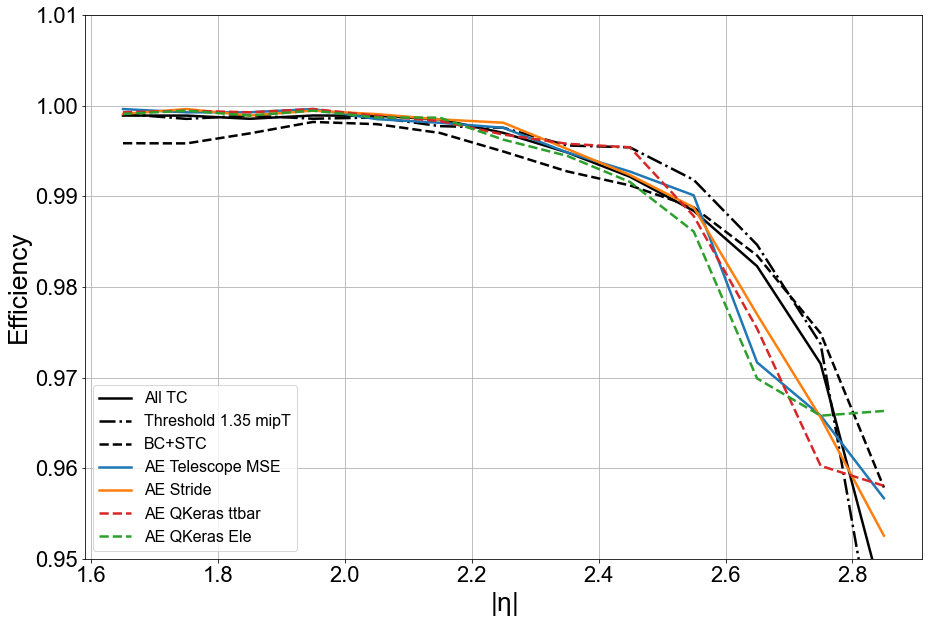

In [26]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = efficiencies_vs_eta[name]
    plt.plot(df.genpart_abseta, df.efficiency, 
             label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0.95, 1.01)
plt.legend(loc = 'lower left', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel('Efficiency')
plt.grid()
plt.savefig('img/electron_id_eta.png')
plt.show()

### Efficiency vs pT

In [21]:
efficiencies_vs_pt = {}
for name,df in dfs_ele.items():
    full = xgb.DMatrix(data=df[inputs['extended']], label=df[output], feature_names=inputs['extended'])
    df['bdt_output'] = boosters['extended'][name].predict(full)
    efficiencies_vs_pt[name] = df.groupby('genpart_binpt').mean()
    efficiencies_vs_pt[name]['efficiency'] = df.groupby('genpart_binpt').apply(lambda x : efficiency(x, bdt_thresholds[name]))

/tmp/ipykernel_21852/2525610188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bdt_output'] = boosters['extended'][name].predict(full)


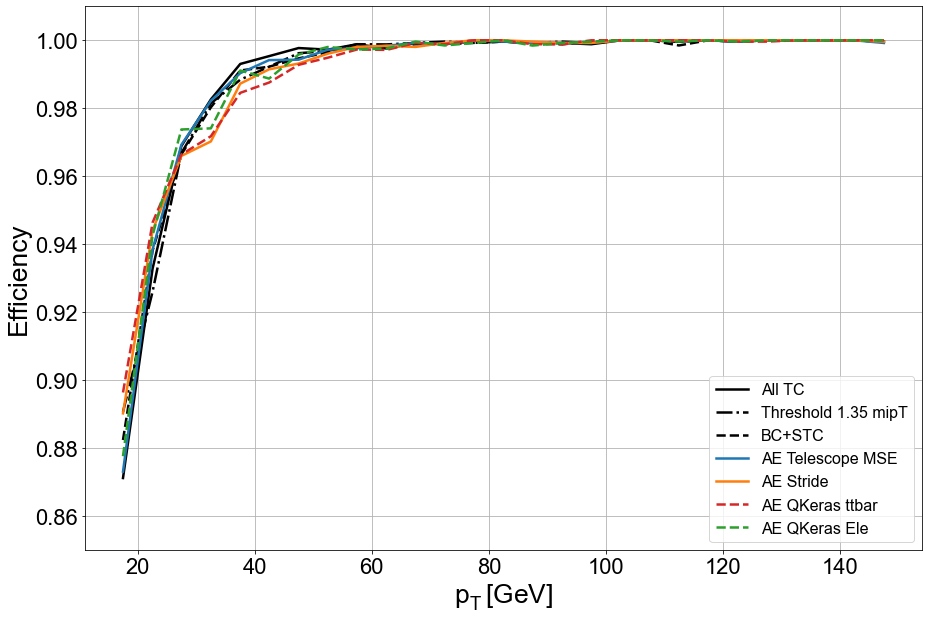

In [27]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10), facecolor='white')
for name in plotted_algo:
    df = efficiencies_vs_pt[name]
    plt.plot(df.genpart_pt, df.efficiency, 
             label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0.85, 1.01)
plt.legend(loc = 'lower right', fontsize=16)
plt.xlabel(r'$p_{T}\,[GeV]$')
plt.ylabel('Efficiency')
plt.grid()
plt.savefig('img/electron_id_pt.png')
plt.show()

## Storing BDTs for external use
Stores as well ROC curves (TPR, FPR, thresholds)

In [23]:
with open('data/xgboost_electron_pu_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(boosters, f)
with open('data/xgboost_fpr_electron_pu_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(fprs, f)
with open('data/xgboost_tpr_electron_pu_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(tprs, f)
with open('data/xgboost_threshold_electron_pu_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(thresholds, f)

In [24]:
print(boosters['extended']['Threshold0'].feature_names)

['cl3d_abseta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz', 'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90']


In [25]:
with open('data/xgboost_electron_pu_autoencoder_210611.pkl', 'rb') as f:
    boosters_2 = pickle.load(f)
print(boosters_2['extended']['Threshold0'].feature_names)

['cl3d_abseta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz', 'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90']
